Kita akan menggunakan beberapa library Python untuk membantu proses manajemen data dan pemrosesan agar lebih efisien 
- pandas: Digunakan untuk menyimpan informasi dalam bentuk dataframe agar mudah dibaca dan dimanipulasi. 
- numpy: Digunakan untuk operasi matemtika, terutama fungsi np.log yang sangat krusial dalam perhitungan probabilitas Naive Bayes. 
- random: Library Python yang akan digunakan nanti dalam algoritma genetika untuk menghasilkan angka acak.
- matplotlib dan seaborn: Tool untuk melakukan visualisasi data.

In [42]:
import pandas as pd
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score

In [43]:
df = pd.read_csv("mushrooms.csv")

print("dataset shape:", df.shape)

dataset shape: (8124, 23)


Dataset berukuran (8124, 23). Ini berarti dataset memiliki 8.124 baris dan 23 kolom. Di mana baris merepresentasikan jumlah total sampel atau observasi jamur yang ada di dalam dataset, sedangkan kolom adalah jumlah atribut atau variabel yang dicatat untuk setiap jamur.


# EDA (Exploratory Data Analysis)

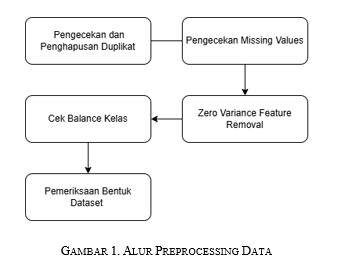

In [44]:
# check duplicates 
duplicates = df.duplicated().sum()
if duplicates > 0: 
    df.drop_duplicates(inplace=True)

In [45]:
# check missing values 
missing = {}
for col in df.columns: 
    if '?' in df[col].unique(): 
        count = df[col].value_counts()['?']
        missing[col] = count 

print(f"missing data: {missing}")

missing data: {'stalk-root': np.int64(2480)}


In [46]:
# use mode to impute missing values 
for col in missing: 
    mode_val = df[col].mode()[0] 
    df[col] = df[col].replace('?', mode_val) 
    print(f"replaced '?' in {col} with {mode_val}")

replaced '?' in stalk-root with b


In [47]:
# check zero variance columns 
drop_cols = []
for col in df.columns: 
    if df[col].nunique() == 1: 
        drop_cols.append(col)

if drop_cols: 
    print(f"dropping zero variance columns (homogen or zero entropy): {drop_cols}")

dropping zero variance columns (homogen or zero entropy): ['veil-type']


Kolom veil-type memiliki hanya satu nilai unik, sehingga tidak memberikan informasi apa pun untuk membedakan kelas. Karena tidak memiliki variasi, fitur ini dihapus karena tidak berkontribusi pada performa model.

In [48]:
# check balance
print(df['class'].value_counts(normalize=True))

class
e    0.517971
p    0.482029
Name: proportion, dtype: float64


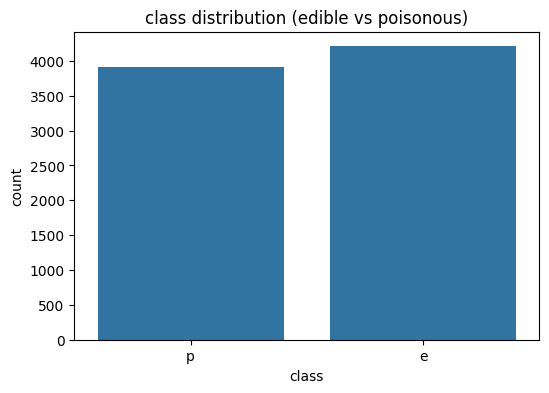

In [49]:
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df)
plt.title("class distribution (edible vs poisonous)")
plt.show()

Setelah melakukan visualisasi untuk melihat distribusi data class dari dataset tersebut, ditemukan bahwa proporsi data Poisonous (P) dan Edible (E) tidak jauh beda. Hasilnya menunjukkan bahwa dataset berada dalam kondisi seimbang, sehingga tidak diperlukan teknik resampling tambahan. 

# shannon entropy

Shannon Entropy adalah ukuran statistik yang menggambarkan tingkat ketidakpastian atau "kekacauan" dalam sekumpulan data; semakin tinggi nilai entropi (mendekati 1), semakin heterogen atau acak isinya (misalnya campuran 50:50 antara jamur beracun dan tidak), sedangkan semakin rendah nilai entropi (mendekati 0), semakin murni atau homogen data tersebut (misalnya 100% jamur beracun), sehingga entropi menjadi tolok ukur utama bagi algoritma untuk menilai seberapa "bersih" sebuah simpul (node) sebelum dan sesudah dilakukan pemecahan.

In [50]:
def calculate_entropy(data_col): 
    counts = data_col.value_counts() 
    total_rows = len(data_col)  

    entropy = 0 
    for count in counts: 
        p_i = count / total_rows 

        if p_i > 0: 
            entropy += -p_i * math.log2(p_i)

    return entropy

# information gain

Information Gain adalah metrik yang digunakan untuk memilih fitur terbaik dalam memecah data dengan cara menghitung selisih antara entropi awal sebelum pemecahan dan rata-rata entropi setelah pemecahan; tujuannya adalah mencari fitur yang memberikan penurunan entropi (pengurangan kekacauan) paling drastis, karena semakin besar nilai Information Gain, berarti fitur tersebut semakin efektif dalam mengelompokkan data ke dalam kelas-kelas yang lebih spesifik dan murni, sehingga fitur itulah yang akan dipilih menjadi cabang keputusan berikutnya dalam pohon.

In [51]:
def calculate_information_gain(data, split_attribute, target_name='class'): 
    total_entropy = calculate_entropy(data[target_name]) 

    vals, counts = np.unique(data[split_attribute], return_counts=True) 
    weighted_entropy = 0 
    total_rows = len(data)

    for i in range(len(vals)):
        subset = data[data[split_attribute] == vals[i]] 
        prop = len(subset) / total_rows 
        subset_entropy = calculate_entropy(subset[target_name]) 
        weighted_entropy += prop * subset_entropy 
    
    # calculate gain 
    gain = total_entropy - weighted_entropy 
    return gain

# ID3

Dalam Decision Tree, data latih disusun menjadi sebuah model yang menyerupai struktur pohon, di mana setiap node merepresentasikan keputusan berdasarkan suatu fitur. Saat membentuk pohon keputusan, Entropy dihitung (Persamaan 1) untuk mengukur ketidakseragaman atau ketidakpastian data pada setiap pemisahan cabang. Selain menghitung Entropi, Information Gain juga dihitung (Persamaan 2) untuk menilai seberapa efektif suatu fitur dalam memisahkan data. Information Gain diperoleh dari selisih Entropi sebelum dan sesudah data dipisahkan menggunakan suatu atribut. Semakin besar perbedaan Entropi, semakin tinggi Information Gain, yang menunjukkan bahwa fitur tersebut mampu memberikan pemisahan data yang lebih informatif dan bermakna.

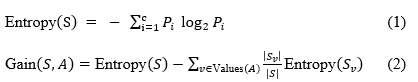

Penggunaan ID3 dikarenakan seluruh fitur pada dataset bersifat kategorikal, sehingga algoritma ini dapat memproses data diskrit secara langsung tanpa memerlukan encoding tambahan. ID3 juga menggunakan Entropy dan Information Gain untuk menentukan atribut terbaik pada setiap pemisahan, sehingga struktur pohon yang dihasilkan lebih optimal. Selain itu, ID3 bersifat sederhana dan mudah diinterpretasikan, sehingga aturan keputusan yang terbentuk dapat dipahami dengan jelas

In [52]:
def id3(data, original_data, features, target_attribute_name="class", parent_node_class=None): 
    unique_classes = np.unique(data[target_attribute_name]) 
    if len(unique_classes) <= 1: 
        return unique_classes[0]
    
    elif len(data) == 0: 
        return np.unique(original_data[target_attribute_name])[np.argmax(np.unique(original_data[target_attribute_name], return_counts=True)[1])]
    
    elif len(features) == 0: 
        return parent_node_class
    
    else: 
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])]

        item_values = [calculate_information_gain(data, feature, target_attribute_name) for feature in features]
        best_feature_idx = np.argmax(item_values)
        best_feature = features[best_feature_idx]

        tree = {best_feature: {}}

        features = [i for i in features if i != best_feature] 

        for value in np.unique(data[best_feature]): 
            sub_data = data.where(data[best_feature] == value).dropna()

            subtree = id3(sub_data, original_data, features, target_attribute_name, parent_node_class)

            tree[best_feature][value] = subtree

        return tree

In [53]:
# data splitting
training_data = df.sample(frac=0.8, random_state=42) 
test_data = df.drop(training_data.index)

training_data, test_data

(     class cap-shape cap-surface cap-color bruises odor gill-attachment  \
 1971     e         f           f         n       f    n               f   
 6654     p         f           s         e       f    y               f   
 5606     p         x           y         n       f    f               f   
 3332     e         f           y         g       t    n               f   
 6988     p         f           s         e       f    s               f   
 ...    ...       ...         ...       ...     ...  ...             ...   
 7830     e         k           s         g       f    n               f   
 5000     p         f           f         y       f    f               f   
 5853     p         b           s         w       t    n               f   
 1279     e         f           s         w       f    n               f   
 7250     p         k           s         n       f    y               f   
 
      gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
 1971        

In [54]:
features = df.columns[1:].tolist()
tree_model = id3(training_data, training_data, features, "class")

In [55]:
import pprint
print("Decision Tree Rules (First Level):")
pprint.pprint(tree_model, depth=2)

Decision Tree Rules (First Level):
{'odor': {'a': 'e',
          'c': 'p',
          'f': 'p',
          'l': 'e',
          'm': 'p',
          'n': {...},
          'p': 'p',
          's': 'p',
          'y': 'p'}}


# Evaluation

Model dievaluasi menggunakan akurasi sebagai metrik utama, yang dihitung dengan membagi jumlah prediksi benar terhadap total prediksi yang dihasilkan model. Selain akurasi, evaluasi dapat diperkuat dengan confusion matrix serta perhitungan precision, recall, dan F1-score sebagai metrik tambahan untuk memberikan gambaran yang lebih komprehensif mengenai performa model.

Prosedur evaluasi dilakukan dengan menggunakan 20% data testing yang diperoleh dari proses split. Model ID3 digunakan untuk melakukan prediksi terhadap data tersebut. Setelah prediksi dihasilkan, akurasi masing-masing model dihitung dan kemudian dibandingkan untuk menentukan model mana yang memberikan performa terbaik dalam memprediksi kelas jamur.

In [56]:
def predict(query, tree, default=None):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]] 
            except:
                return default
  
            result = tree[key][query[key]]
            
            if isinstance(result, dict):
                return predict(query, result)
            else:
                return result

In [57]:
def test_accuracy(data, tree):
    queries = data.to_dict(orient="records")
    predicted = []
    for i in range(len(data)):
        predicted.append(predict(queries[i], tree, 'p'))
        
    actual = data["class"].tolist()
    
    correct = 0
    for i in range(len(actual)):
        if predicted[i] == actual[i]:
            correct += 1
    return correct / len(actual)

In [58]:
tree_model

{'odor': {'a': 'e',
  'c': 'p',
  'f': 'p',
  'l': 'e',
  'm': 'p',
  'n': {'spore-print-color': {'b': 'e',
    'h': 'e',
    'k': 'e',
    'n': 'e',
    'o': 'e',
    'r': 'p',
    'w': {'habitat': {'d': {'gill-size': {'b': 'e', 'n': 'p'}},
      'g': 'e',
      'l': {'cap-color': {'c': 'e', 'n': 'e', 'w': 'p', 'y': 'p'}},
      'p': 'e',
      'w': 'e'}},
    'y': 'e'}},
  'p': 'p',
  's': 'p',
  'y': 'p'}}

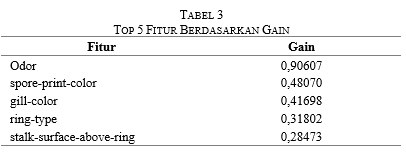

Tabel 3 tersebut menunjukkan lima fitur paling berpengaruh dalam proses pemilihan atribut pada algoritma ID3. Nilai gain yang lebih tinggi menandakan bahwa fitur tersebut mampu membagi data secara lebih informatif dalam memprediksi kelas jamur (edible atau poisonous).

Fitur odor memiliki information gain tertinggi (0,90607), sehingga menjadi atribut utama yang memengaruhi keputusan model. Fitur lain seperti spore-print-color, gill-color, ring-type, dan stalk-surface-above-ring juga berkontribusi signifikan, namun tidak sekuat odor. Urutan ini menggambarkan tingkat kepentingan masing-masing fitur dalam membentuk struktur pohon keputusan.

Struktur decision tree di atas menunjukkan aturan pemilihan atribut pada model Decision Tree yang dibangun menggunakan algoritma ID3. Atribut utama yang digunakan sebagai pemisah pertama adalah odor, karena memiliki information gain tertinggi. Setiap nilai pada fitur odor langsung mengarah ke prediksi kelas, misalnya nilai 'a', 'l', dan 'n' mengarah ke edible, sedangkan nilai 'c', 'f', 'm', 'p', 's', dan 'y' mengarah ke poisonous.

Untuk kasus ketika odor bernilai 'n', pohon melakukan pemisahan lanjutan menggunakan fitur spore-print-color. Jika masih belum memberikan kepastian, atribut berikutnya seperti habitat, gill-size, atau cap-color digunakan untuk memperjelas klasifikasi. Struktur ini memperlihatkan bagaimana model mengambil keputusan secara bertahap berdasarkan nilai fitur yang paling informatif hingga mencapai kelas akhir (edible atau poisonous).

In [59]:
acc = test_accuracy(test_data, tree_model)
print(f"accuracy: {acc * 100:.2f}%")

accuracy: 100.00%


In [ ]:
queries = test_data.to_dict(orient="records")
y_pred = []
y_true = test_data["class"].tolist()

for i in range(len(test_data)):
    prediction = predict(queries[i], tree_model, default='p')
    y_pred.append(prediction)

F1 Score (Poisonous): 1.0000


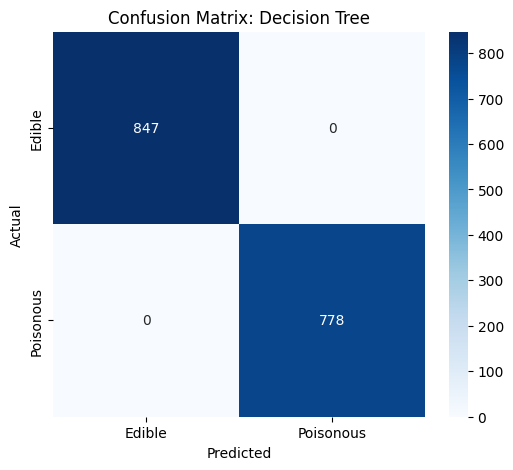

In [61]:
f1 = f1_score(y_true, y_pred, pos_label='p')
print(f"F1 Score (Poisonous): {f1:.4f}")

cm = confusion_matrix(y_true, y_pred, labels=['e', 'p'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Edible', 'Poisonous'], 
            yticklabels=['Edible', 'Poisonous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Decision Tree')
plt.show()